In [1]:
import numpy as np
import pandas as pd
import math
import time
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.feature_extraction.text import TfidfTransformer
from kmodes.kmodes import KModes
from scipy.spatial.distance import pdist, squareform

# 1. RFM Clustering

In [2]:
df = pd.read_csv("order_clean_join_all.csv")
df.head()

/var/folders/bj/kty340bx2c5fb8txjv7svs8r0000gn/T/ipykernel_47315/1767332170.py:1: DtypeWarning: Columns (14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("order_clean_join_all.csv")


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,gender,dob,LOCATION_TYPE,latitude,longitude,latitude_vendor,longtitude_vendor,vendor_category_en,delivery_charge,vendor_tag_name
0,163238.0,92PEE24,1.0,7.6,2,0,0.0,0.0,No,No,...,Male,NaN,Other,-0.132100,-78.575297,-0.967769,0.080839,Restaurants,0.0,"American,Burgers,Free Delivery,Hot Dogs,Pasta"
1,163240.0,QS68UD8,1.0,8.7,1,0,0.0,0.0,No,No,...,Unknown,NaN,Work,-0.393396,-78.544417,-1.271979,0.028832,Restaurants,0.0,"Burgers,Desserts,Free Delivery,Grills,Mexican"
2,163241.0,MB7VY5F,2.0,14.4,1,0,0.0,0.0,No,No,...,Unknown,NaN,Other,-1.072823,-78.464121,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic"
3,163244.0,KDJ951Y,1.0,7.1,1,0,0.0,0.0,No,No,...,Male,NaN,Home,-0.292713,-78.556316,-0.601096,0.095998,Restaurants,0.0,"American,Burgers,Desserts,Mojitos ,Pasta"
4,163245.0,BAL0RVT,4.0,27.2,1,0,0.0,0.0,No,No,...,Male,NaN,Work,-0.231810,-78.563513,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic"


In [3]:
df['vendor_rating'].unique()

array([0., 5., 4., 2., 1., 3.])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135216 entries, 0 to 135215
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   akeed_order_id                  135216 non-null  float64
 1   customer_id                     135216 non-null  object 
 2   item_count                      135216 non-null  float64
 3   grand_total                     135216 non-null  float64
 4   payment_mode                    135216 non-null  int64  
 5   promo_code                      135216 non-null  int64  
 6   vendor_discount_amount          135216 non-null  float64
 7   promo_code_discount_percentage  135216 non-null  float64
 8   is_favorite                     135216 non-null  object 
 9   is_rated                        135216 non-null  object 
 10  vendor_rating                   135216 non-null  float64
 11  driver_rating                   135216 non-null  float64
 12  deliverydistance

In [5]:
df[['order_accepted_time', 'ready_for_pickup_time', 'delivery_date', 'created_at']][df.any(axis = 1)].sample(n = 50)

,order_accepted_time,ready_for_pickup_time,delivery_date,created_at
119646,2020-02-10 15:22:51,2020-02-10 15:23:01,NaN,2020-02-10 15:22:35
12105,NaN,NaN,2019-09-10 05:30:00,2019-09-11 04:10:56
39082,NaN,NaN,NaN,2019-10-02 02:24:28
10877,NaN,NaN,2019-09-07 05:30:00,2019-09-08 04:55:59
10931,NaN,NaN,2019-09-08 05:30:00,2019-09-08 16:34:15
100425,2020-01-15 19:33:23,2020-01-15 21:58:22,NaN,2020-01-15 19:31:15
56516,2019-11-03 06:24:36,2019-11-03 06:26:30,NaN,2019-11-03 10:23:50
19908,NaN,NaN,2019-07-14 05:30:00,2019-07-14 20:01:01
2434,NaN,NaN,2019-08-08 05:30:00,2019-08-08 15:55:58
7707,NaN,NaN,2019-08-27 05:30:00,2019-08-28 04:01:33


It can be seen that most of the cases have the same day or just a difference of 1 day discrepancy, so here for the RFM, I will use the created_at as their order date.

In [6]:
df['order_date'] = pd.to_datetime(df['created_at']).dt.date

In [7]:
df.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,dob,LOCATION_TYPE,latitude,longitude,latitude_vendor,longtitude_vendor,vendor_category_en,delivery_charge,vendor_tag_name,order_date
0,163238.0,92PEE24,1.0,7.6,2,0,0.0,0.0,No,No,...,NaN,Other,-0.132100,-78.575297,-0.967769,0.080839,Restaurants,0.0,"American,Burgers,Free Delivery,Hot Dogs,Pasta",2019-08-01
1,163240.0,QS68UD8,1.0,8.7,1,0,0.0,0.0,No,No,...,NaN,Work,-0.393396,-78.544417,-1.271979,0.028832,Restaurants,0.0,"Burgers,Desserts,Free Delivery,Grills,Mexican",2019-08-01
2,163241.0,MB7VY5F,2.0,14.4,1,0,0.0,0.0,No,No,...,NaN,Other,-1.072823,-78.464121,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic",2019-08-01
3,163244.0,KDJ951Y,1.0,7.1,1,0,0.0,0.0,No,No,...,NaN,Home,-0.292713,-78.556316,-0.601096,0.095998,Restaurants,0.0,"American,Burgers,Desserts,Mojitos ,Pasta",2019-08-01
4,163245.0,BAL0RVT,4.0,27.2,1,0,0.0,0.0,No,No,...,NaN,Work,-0.231810,-78.563513,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic",2019-08-01


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135216 entries, 0 to 135215
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   akeed_order_id                  135216 non-null  float64
 1   customer_id                     135216 non-null  object 
 2   item_count                      135216 non-null  float64
 3   grand_total                     135216 non-null  float64
 4   payment_mode                    135216 non-null  int64  
 5   promo_code                      135216 non-null  int64  
 6   vendor_discount_amount          135216 non-null  float64
 7   promo_code_discount_percentage  135216 non-null  float64
 8   is_favorite                     135216 non-null  object 
 9   is_rated                        135216 non-null  object 
 10  vendor_rating                   135216 non-null  float64
 11  driver_rating                   135216 non-null  float64
 12  deliverydistance

In [9]:
max_date = df['order_date'].max()
snapshot_date = max_date + dt.timedelta(days = 1)
snapshot_date

datetime.date(2020, 3, 1)

In [10]:
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'akeed_order_id': 'count',
    'grand_total': sum
})
rfm.rename(columns = {'order_date': 'Recency', 'akeed_order_id': 'Frequency', 'grand_total': 'Monetary'}, inplace = True)
rfm

/var/folders/bj/kty340bx2c5fb8txjv7svs8r0000gn/T/ipykernel_47315/1399846866.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rfm = df.groupby('customer_id').agg({


,Recency,Frequency,Monetary
customer_id,,,
000THBA,139,1,29.6
002510Y,270,1,13.6
005ECL6,44,2,48.7
0075AM7,7,1,25.8
009UFS1,80,4,29.6
...,...,...,...
ZZVGIVK,110,2,38.6
ZZVLIB5,14,12,504.4
ZZWKMGG,253,1,22.2


In [11]:
rfm.describe()

,Recency,Frequency,Monetary
count,27442.000000,27442.000000,27442.000000
mean,71.723490,4.927338,75.784280
std,72.220807,7.619244,141.219577
min,1.000000,1.000000,0.000000
25%,15.000000,1.000000,13.900000
50%,42.000000,2.000000,31.500000
75%,109.000000,5.000000,80.600000
max,274.000000,262.000000,3965.500000


In [12]:
rfm[rfm['Monetary'] == 0]

,Recency,Frequency,Monetary
customer_id,,,
098AGWK,192,1,0.0
09PW8ST,74,2,0.0
0DT7TCF,118,1,0.0
0H5X6WN,29,1,0.0
0HMKWHG,31,1,0.0
...,...,...,...
ZF5SBGM,33,1,0.0
ZOGKK6R,103,1,0.0
ZQ9ENCL,103,1,0.0


In [13]:
df[df['customer_id'] == '098AGWK']

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,dob,LOCATION_TYPE,latitude,longitude,latitude_vendor,longtitude_vendor,vendor_category_en,delivery_charge,vendor_tag_name,order_date
5750,175110.0,098AGWK,3.0,0.0,1,1,0.0,0.0,No,No,...,NaN,Other,-1.134433,-78.45684,2.215692,0.714018,Restaurants,0.7,NaN,2019-08-22


What's wierd is that the grand_total is 0, but item_count is 3. This might be due to a misentered value in the system. To avoid errors or confusion, we’ll drop this record.

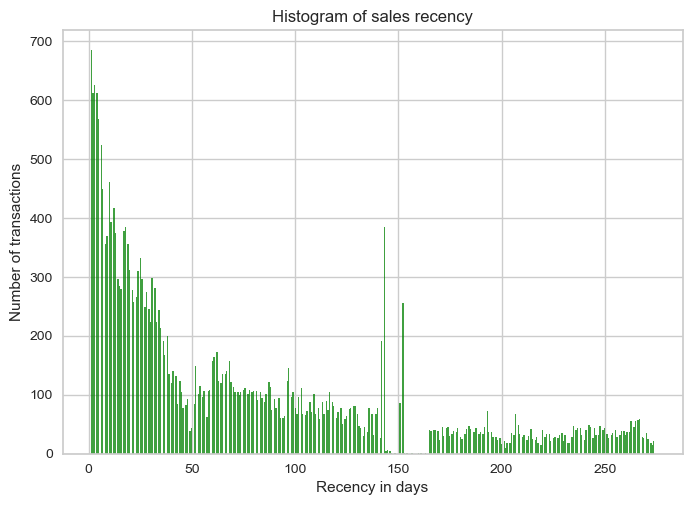

In [14]:
#Recency plot
x = rfm.Recency
mu = np.mean(rfm.Recency)
sigma = math.sqrt(np.var(rfm.Recency))
n, bins, patches = plt.hist(x, 400, facecolor='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales recency')
plt.grid(True)

In [15]:
rfm['Log_Monetary'] = np.where(rfm['Monetary'] == 0, 0, np.log(rfm['Monetary']))

rfm_cluster = rfm[['Recency', 'Frequency', "Log_Monetary"]]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_cluster)

/opt/anaconda3/envs/zfq0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


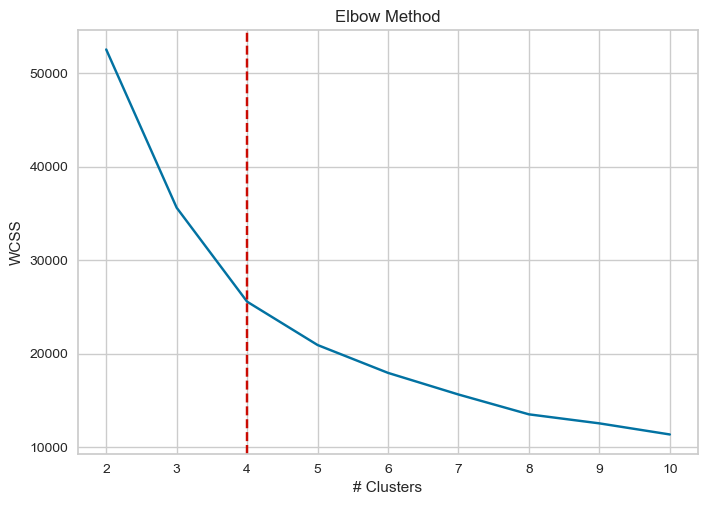

In [16]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state=123)
    kmeans.fit_predict(rfm_scaled)
    wcss.append(kmeans.inertia_)

knee_locator = KneeLocator(range(2, 11), wcss, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

plt.plot(range(2, 11), wcss)
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("Elbow Method")
plt.xlabel("# Clusters")
plt.ylabel("WCSS")
plt.show();

Based on the elbow method plot, the best cluster is when k = 4.

In [17]:
kmeans = KMeans(n_clusters = 4, random_state = 123)
rfm['K-Means'] = kmeans.fit_predict(rfm_scaled)

In [18]:
rfm

,Recency,Frequency,Monetary,Log_Monetary,K-Means
customer_id,,,,,
000THBA,139,1,29.6,3.387774,1
002510Y,270,1,13.6,2.610070,1
005ECL6,44,2,48.7,3.885679,0
0075AM7,7,1,25.8,3.250374,3
009UFS1,80,4,29.6,3.387774,3
...,...,...,...,...,...
ZZVGIVK,110,2,38.6,3.653252,3
ZZVLIB5,14,12,504.4,6.223370,0
ZZWKMGG,253,1,22.2,3.100092,1


In [19]:
cluster_stats = rfm.groupby('K-Means').agg({'Recency': 'mean',
                                            'Frequency': 'mean',
                                            'Monetary': 'mean',
                                            'K-Means': 'count'}).rename(columns={'K-Means': 'Count'})
print("\nCluster Statistics:")
print(cluster_stats)


Cluster Statistics:
            Recency  Frequency    Monetary  Count
K-Means                                          
0         36.528957   7.125175  114.699248   9307
1        188.669540   1.781440   26.714790   5916
2         17.377711  30.243082  493.567091   1337
3         44.923543   1.647491   17.848043  10882


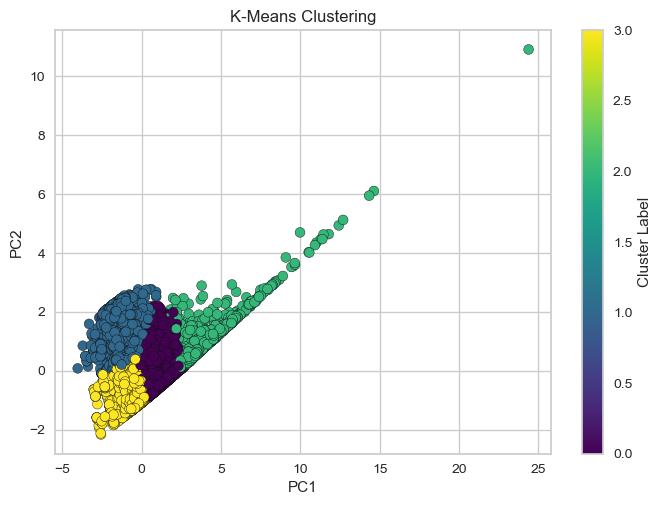

In [20]:
pca = PCA(n_components=2)
pca_df = pca.fit_transform(rfm_scaled)

plt.scatter(pca_df[:, 0], pca_df[:, 1], c=rfm['K-Means'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("K-Means Clustering")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Label')
plt.show()

In [21]:
# hyperparameter
eps_values = np.arange(0.1, 5.1, 0.2)
min_samples_values = list(range(2, 10))

# to keep track of the best Silhouette score
best_score = -1  
best_eps = None
best_min_samples = None
best_model = None

# for loop for all combinations of the hyperarameters
for eps in eps_values:
    for min_samples in min_samples_values:
        # DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        y_pred = dbscan.fit_predict(rfm_scaled)

        # ignore the -1 because it is noise and check at least 2 clusters are exist
        # remove noise
        unique_labels = set(y_pred) - {-1}  
        # at least more than 1 cluster
        if len(unique_labels) > 1:  
            cluster_labels = y_pred[y_pred != -1]
            X_clustered = rfm_scaled[y_pred != -1]
            silhouette_avg = silhouette_score(X_clustered, cluster_labels)
        else:
            # if cluster = 1, silhouette score = -1
            silhouette_avg = -1  

        # update the best model
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_eps = eps
            best_min_samples = min_samples
            best_model = dbscan

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_score}")

Best eps: 1.1
Best min_samples: 2
Best Silhouette Score: 0.8918951742164918


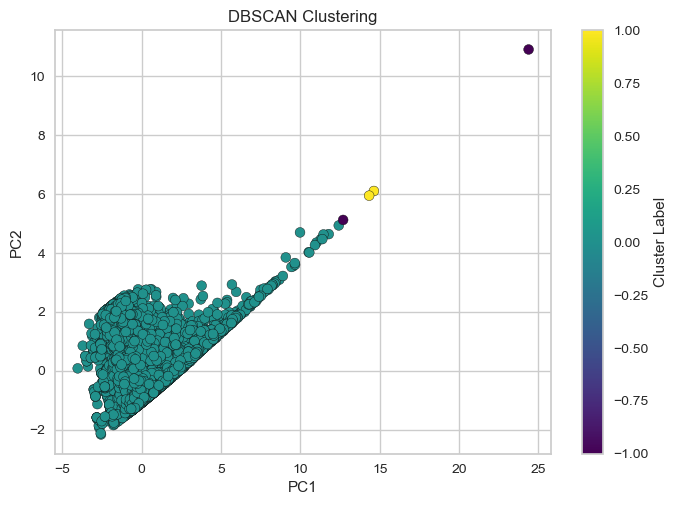

In [22]:
pca = PCA(n_components=2)
pca_df = pca.fit_transform(rfm_scaled)

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
y_pred = dbscan.fit_predict(rfm_scaled)

plt.scatter(pca_df[:, 0], pca_df[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("DBSCAN Clustering")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Label')
plt.show()

In [23]:
rfm

,Recency,Frequency,Monetary,Log_Monetary,K-Means
customer_id,,,,,
000THBA,139,1,29.6,3.387774,1
002510Y,270,1,13.6,2.610070,1
005ECL6,44,2,48.7,3.885679,0
0075AM7,7,1,25.8,3.250374,3
009UFS1,80,4,29.6,3.387774,3
...,...,...,...,...,...
ZZVGIVK,110,2,38.6,3.653252,3
ZZVLIB5,14,12,504.4,6.223370,0
ZZWKMGG,253,1,22.2,3.100092,1


In [24]:
cluster_stats

,Recency,Frequency,Monetary,Count
K-Means,,,,
0,36.528957,7.125175,114.699248,9307
1,188.669540,1.781440,26.714790,5916
2,17.377711,30.243082,493.567091,1337
3,44.923543,1.647491,17.848043,10882


Based on the cluster stats:
- Cluster 2: Super User -> most engage and the highest spender
- Cluster 0: Regular user -> cosistent spending on the app, but not as crazy as the second cluster
- Cluster 1: Lost User -> average recency is 188 days, which means they had disappear already
- Cluster 3: Churn User -> on average only use 1.7x, which means only trying the apps and that's it. Maybe they got discount on the app that's why trying on it, then it doesn't come back anymore.

In [25]:
cluster_mapping = {
    0: 'regular_user',
    1: 'churn_user',
    2: 'super_user',
    3: 'lost_user'
}
rfm["Segment"] = rfm["K-Means"].map(cluster_mapping)
rfm = rfm.reset_index()
rfm

,customer_id,Recency,Frequency,Monetary,Log_Monetary,K-Means,Segment
0,000THBA,139,1,29.6,3.387774,1,churn_user
1,002510Y,270,1,13.6,2.610070,1,churn_user
2,005ECL6,44,2,48.7,3.885679,0,regular_user
3,0075AM7,7,1,25.8,3.250374,3,lost_user
4,009UFS1,80,4,29.6,3.387774,3,lost_user
...,...,...,...,...,...,...,...
27437,ZZVGIVK,110,2,38.6,3.653252,3,lost_user
27438,ZZVLIB5,14,12,504.4,6.223370,0,regular_user
27439,ZZWKMGG,253,1,22.2,3.100092,1,churn_user
27440,ZZY3N0D,6,9,67.6,4.213608,0,regular_user


In [26]:
df_segment = pd.merge(df, rfm[['customer_id', 'Segment']], how='left', on = 'customer_id')
df_segment

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,LOCATION_TYPE,latitude,longitude,latitude_vendor,longtitude_vendor,vendor_category_en,delivery_charge,vendor_tag_name,order_date,Segment
0,163238.0,92PEE24,1.0,7.6,2,0,0.0,0.0,No,No,...,Other,-0.132100,-78.575297,-0.967769,0.080839,Restaurants,0.0,"American,Burgers,Free Delivery,Hot Dogs,Pasta",2019-08-01,churn_user
1,163240.0,QS68UD8,1.0,8.7,1,0,0.0,0.0,No,No,...,Work,-0.393396,-78.544417,-1.271979,0.028832,Restaurants,0.0,"Burgers,Desserts,Free Delivery,Grills,Mexican",2019-08-01,churn_user
2,163241.0,MB7VY5F,2.0,14.4,1,0,0.0,0.0,No,No,...,Other,-1.072823,-78.464121,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic",2019-08-01,churn_user
3,163244.0,KDJ951Y,1.0,7.1,1,0,0.0,0.0,No,No,...,Home,-0.292713,-78.556316,-0.601096,0.095998,Restaurants,0.0,"American,Burgers,Desserts,Mojitos ,Pasta",2019-08-01,churn_user
4,163245.0,BAL0RVT,4.0,27.2,1,0,0.0,0.0,No,No,...,Work,-0.231810,-78.563513,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic",2019-08-01,regular_user
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135211,415507.0,L6LFY6H,1.0,13.3,2,0,0.0,0.0,No,No,...,Other,-0.207822,0.473790,-0.181038,0.490518,Restaurants,0.0,"Breakfast,Desserts,Grills,Milkshakes,Salads,Sa...",2020-02-29,regular_user
135212,415508.0,2GMMVGI,3.0,9.5,1,0,0.0,0.0,No,Yes,...,Work,1.742466,0.377535,0.634654,0.527255,Restaurants,0.0,"Burgers,Desserts,Free Delivery,Pasta,Sandwiches",2020-02-29,regular_user
135213,415510.0,LYTAAV0,4.0,18.2,2,0,0.0,0.0,No,No,...,Other,0.688098,0.417760,0.480602,0.552850,Restaurants,0.7,Burgers,2020-02-29,regular_user
135214,415512.0,NEV9A5D,3.0,7.7,1,1,0.0,0.0,No,No,...,Other,-0.701674,0.724363,-0.496138,0.740214,Restaurants,0.0,"American,Breakfast,Burgers,Cafe,Desserts,Free ...",2020-02-29,lost_user


CLV -> customer lifetime value monthly basis
30 days CLV = Average Order value * purchas frequency per month

Average order value = Total revenue / total orders
Purchases frequency per month = average number of puchases a customer makes in 30 days

In [27]:
df_segment['order_date'] = pd.to_datetime(df_segment['order_date'], errors='coerce')
df_segment['year_month'] = df_segment['order_date'].dt.to_period('M')
monthly_orders = df_segment.groupby(['Segment', 'year_month'])['akeed_order_id'].count().reset_index()
monthly_users = df_segment.groupby(['Segment', 'year_month'])['customer_id'].nunique().reset_index()

monthly_orders = monthly_orders.merge(monthly_users, on=['Segment', 'year_month'], how='left')
monthly_orders['Avg_Orders_Per_User_Per_Month'] = monthly_orders['akeed_order_id'] / monthly_orders['customer_id']
avg_monthly_orders_per_segment = monthly_orders.groupby('Segment')['Avg_Orders_Per_User_Per_Month'].mean().reset_index()
avg_monthly_orders_per_segment.columns = ['Segment', 'Avg_Orders_Per_Month_Per_User']
avg_monthly_orders_per_segment

,Segment,Avg_Orders_Per_Month_Per_User
0,churn_user,1.304124
1,lost_user,1.159952
2,regular_user,1.938975
3,super_user,4.336164


In [28]:
cluster_stats_val = cluster_stats.reset_index()
cluster_stats_val["Segment"] = cluster_stats_val["K-Means"].map(cluster_mapping)
cluster_stats_val['avg_order_value'] = cluster_stats_val['Monetary']/cluster_stats_val['Frequency']
cluster_stats_val

,K-Means,Recency,Frequency,Monetary,Count,Segment,avg_order_value
0,0,36.528957,7.125175,114.699248,9307,regular_user,16.097746
1,1,188.669540,1.781440,26.714790,5916,churn_user,14.996176
2,2,17.377711,30.243082,493.567091,1337,super_user,16.320000
3,3,44.923543,1.647491,17.848043,10882,lost_user,10.833467


In [29]:
clv_df = pd.merge(avg_monthly_orders_per_segment, cluster_stats_val[['Segment', 'avg_order_value']], how='left', on = 'Segment')
clv_df

,Segment,Avg_Orders_Per_Month_Per_User,avg_order_value
0,churn_user,1.304124,14.996176
1,lost_user,1.159952,10.833467
2,regular_user,1.938975,16.097746
3,super_user,4.336164,16.320000


In [30]:
clv_df['CLV_30'] = clv_df['Avg_Orders_Per_Month_Per_User'] * clv_df['avg_order_value']
clv_df

,Segment,Avg_Orders_Per_Month_Per_User,avg_order_value,CLV_30
0,churn_user,1.304124,14.996176,19.556869
1,lost_user,1.159952,10.833467,12.566307
2,regular_user,1.938975,16.097746,31.213122
3,super_user,4.336164,16.320000,70.766199


# 2. Cuisine Preference Clustering

In [31]:
data=pd.read_csv("order_clean_join_all.csv")

/var/folders/bj/kty340bx2c5fb8txjv7svs8r0000gn/T/ipykernel_47315/2350089385.py:1: DtypeWarning: Columns (14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("order_clean_join_all.csv")


In [32]:
temp=data['vendor_tag_name'].str.get_dummies(sep=',')
data=pd.concat([data.drop(columns=['vendor_tag_name']), temp], axis=1)

In [33]:
data.columns

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'order_accepted_time', 'driver_accepted_time', 'ready_for_pickup_time',
       'picked_up_time', 'delivered_time', 'delivery_date', 'vendor_id',
       'created_at', 'LOCATION_NUMBER', 'gender', 'dob', 'LOCATION_TYPE',
       'latitude', 'longitude', 'latitude_vendor', 'longtitude_vendor',
       'vendor_category_en', 'delivery_charge', 'American', 'Arabic', 'Asian',
       'Bagels', 'Biryani', 'Breakfast', 'Burgers', 'Cafe', 'Cakes', 'Chinese',
       'Churros', 'Coffee', 'Combos', 'Crepes', 'Desserts', 'Dimsum', 'Donuts',
       'Family Meal', 'Fatayers', 'Free Delivery', 'Fresh Juices', 'Fries',
       'Frozen yoghurt', 'Grills', 'Healthy Food', 'Hot Chocolate', 'Hot Dogs',
       'Ice creams', 'India

In [34]:
columns=['customer_id','American', 'Arabic', 'Asian',
       'Bagels', 'Biryani', 'Breakfast', 'Burgers', 'Cafe', 'Cakes', 'Chinese',
       'Churros', 'Coffee', 'Combos', 'Crepes', 'Desserts', 'Dimsum', 'Donuts',
       'Family Meal', 'Fatayers', 'Free Delivery', 'Fresh Juices', 'Fries',
       'Frozen yoghurt', 'Grills', 'Healthy Food', 'Hot Chocolate', 'Hot Dogs',
       'Ice creams', 'Indian', 'Italian', 'Japanese', 'Karak', 'Kebabs',
       'Kids meal', 'Kushari', 'Lebanese', 'Manakeesh', 'Mandazi', 'Mexican',
       'Milkshakes', 'Mishkak', 'Mojitos', 'Mojitos ', 'Omani', 'Organic',
       'Pancakes', 'Pasta', 'Pastas', 'Pastry', 'Pizza', 'Pizzas', 'Rice',
       'Rolls', 'Salads', 'Sandwiches', 'Seafood', 'Shawarma', 'Shuwa',
       'Smoothies', 'Soups', 'Spanish Latte', 'Steaks', 'Sushi', 'Sweets',
       'Thai', 'Thali', 'Vegetarian', 'Waffles']
data1=data[columns]

In [35]:
def find_optimal_k(customer_df):
    features = customer_df.drop(columns=['customer_id'])
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    distortions = []
    silhouette_scores = []
    K_range = range(2, 10)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
        labels = kmeans.fit_predict(scaled_features)
        distortions.append(kmeans.inertia_)
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.set_xlabel("Number of Clusters (k)")
    ax1.set_ylabel("Distortion Score", color="blue")
    ax1.plot(K_range, distortions, marker="o", linestyle="--", color="blue", label="Distortion")
    ax1.tick_params(axis="y", labelcolor="blue")
    plt.title("Elbow Method")
    plt.show()

## 2.1 K-Means Clustering

In [36]:
df=data1.groupby('customer_id').sum().reset_index()
df=pd.DataFrame(df)
df

,customer_id,American,Arabic,Asian,Bagels,Biryani,Breakfast,Burgers,Cafe,Cakes,...,Smoothies,Soups,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles
0,000THBA,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,002510Y,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,005ECL6,2,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0075AM7,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,009UFS1,1,2,0,0,0,2,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27437,ZZVGIVK,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
27438,ZZVLIB5,0,0,9,0,0,1,1,0,0,...,1,9,0,0,0,0,0,0,0,0
27439,ZZWKMGG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27440,ZZY3N0D,2,1,0,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,0,1


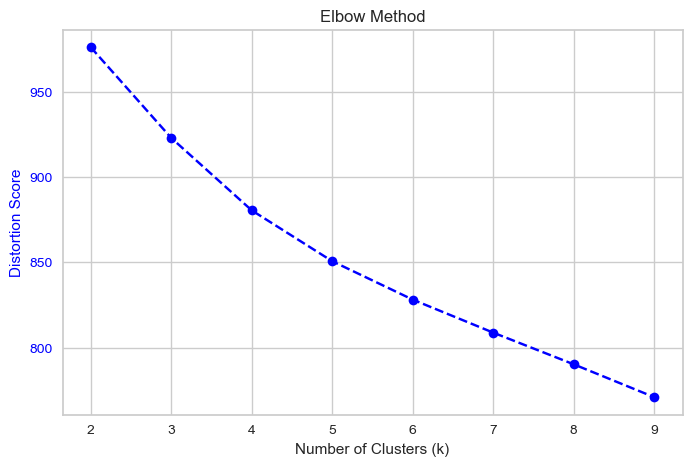

In [37]:
find_optimal_k(df)

Elbow Method: The curve bends around k = 4

In [38]:
optimal_k = 4
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['customer_id']))
kmeans = KMeans(n_clusters=optimal_k, random_state=123, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)


In [39]:
centroids = pd.DataFrame(kmeans.cluster_centers_,columns=df.drop(columns=['customer_id', 'KMeans_Cluster']).columns)
centroids

,American,Arabic,Asian,Bagels,Biryani,Breakfast,Burgers,Cafe,Cakes,Chinese,...,Smoothies,Soups,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles
0,0.008173,0.007403,0.001240,0.000779,0.001563,0.003145,0.013525,0.004122,0.000528,0.001267,...,0.001301,0.002122,0.000609,0.001513,0.000256,0.000811,0.002184,0.000508,0.000508,0.003559
1,0.038099,0.013866,0.000190,0.000234,0.001329,0.006568,0.048811,0.006910,0.018450,0.007480,...,0.000862,0.002521,0.026274,0.003156,0.000095,0.000943,0.004582,0.000062,0.000062,0.176966
2,0.109715,0.130089,0.028902,0.012759,0.009527,0.059939,0.215518,0.027775,0.008340,0.039872,...,0.036364,0.038395,0.004147,0.039528,0.010054,0.030983,0.036364,0.000714,0.000714,0.018294
3,0.052662,0.045109,0.006988,0.003680,0.004069,0.018136,0.086459,0.021273,0.001545,0.007897,...,0.008800,0.011278,0.001423,0.010197,0.001589,0.005461,0.009496,0.000972,0.000972,0.007209


In [40]:
centroids.apply(lambda row: row.sort_values(ascending=False).index.tolist(), axis=1)

0    [Burgers, Desserts, Free Delivery, Shawarma, K...
1    [Waffles, Pancakes, Donuts, Ice creams, Milksh...
2    [Grills, Burgers, Shawarma, Desserts, Mojitos ...
3    [Burgers, Free Delivery, Desserts, American, K...
dtype: object

In [41]:
# Trimming down categories
df=data1.groupby('customer_id').sum().reset_index()
df=pd.DataFrame(df)

food_mapping = {
    "American": ["American", "Bagels", "Burgers", "Fries", "Grills", "Hot Dogs", "Rolls", "Steaks"],
    "Arabic": ["Arabic", "Fatayers", "Kebabs", "Kushari", "Lebanese", "Manakeesh", "Mandazi", "Omani", "Shawarma", "Shuwa"],
    "Asian": ["Asian", "Biryani", "Chinese", "Dimsum", "Indian", "Japanese", "Rice", "Sushi", "Thai", "Thali"],
    "Desserts": ["Cakes", "Crepes", "Desserts", "Frozen yoghurt", "Ice creams", "Pastry", "Sweets"],
    "Snacks": ["Churros", "Donuts", "Mishkak"],
    "Drinks": ["Coffee", "Fresh Juices", "Hot Chocolate", "Karak", "Milkshakes", "Mojitos", "Spanish Latte"],
    "Health": ["Healthy Food", "Organic", "Salads", "Sandwiches", "Smoothies", "Soups", "Vegetarian"],
    "Italian": ["Italian", "Pasta", "Pastas", "Pizza", "Pizzas"],
    "Mexican": ["Mexican"],
    "Seafood": ["Seafood"],
    "Breakfast": ["Breakfast", "Pancakes", "Waffles"]
}

In [42]:
columns_to_keep = set(sum(food_mapping.values(), [])) 
customer_df_filtered = df[["customer_id"] + [col for col in df.columns if col in columns_to_keep]]
trim_df = pd.DataFrame()
trim_df["customer_id"] = customer_df_filtered["customer_id"]
for category, tags in food_mapping.items():
    available_tags = [tag for tag in tags if tag in customer_df_filtered.columns]
    if available_tags:
        trim_df[category] = customer_df_filtered[available_tags].sum(axis=1)
    else:
        trim_df[category] = 0 

In [43]:
trim_df

,customer_id,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast
0,000THBA,2,1,0,0,0,0,1,1,0,0,1
1,002510Y,0,0,4,1,0,0,1,0,0,0,0
2,005ECL6,6,0,0,2,2,0,4,2,0,0,0
3,0075AM7,0,1,0,0,0,0,1,1,0,0,0
4,009UFS1,7,4,0,2,0,0,3,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
27437,ZZVGIVK,1,0,0,2,0,0,3,4,0,0,1
27438,ZZVLIB5,13,0,36,1,0,3,12,0,0,0,1
27439,ZZWKMGG,0,1,0,0,0,2,1,0,0,0,0
27440,ZZY3N0D,8,5,0,6,1,11,4,2,0,0,3


In [44]:
# perform KMeans clustering again
optimal_k = 3
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(trim_df.drop(columns=['customer_id']))
kmeans = KMeans(n_clusters=optimal_k, random_state=123, n_init=10)
trim_df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
trim_df

,customer_id,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast,KMeans_Cluster
0,000THBA,2,1,0,0,0,0,1,1,0,0,1,0
1,002510Y,0,0,4,1,0,0,1,0,0,0,0,0
2,005ECL6,6,0,0,2,2,0,4,2,0,0,0,0
3,0075AM7,0,1,0,0,0,0,1,1,0,0,0,0
4,009UFS1,7,4,0,2,0,0,3,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27437,ZZVGIVK,1,0,0,2,0,0,3,4,0,0,1,0
27438,ZZVLIB5,13,0,36,1,0,3,12,0,0,0,1,0
27439,ZZWKMGG,0,1,0,0,0,2,1,0,0,0,0,0
27440,ZZY3N0D,8,5,0,6,1,11,4,2,0,0,3,2


In [45]:
centroids = pd.DataFrame(kmeans.cluster_centers_,columns=trim_df.drop(columns=['customer_id', 'KMeans_Cluster']).columns)
centroids

,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast
0,0.011835,0.008512,0.002370,0.005907,0.005231,0.003851,0.003611,0.002435,0.002120,0.000403,0.003991
1,0.208358,0.146828,0.019489,0.069860,0.125253,0.069750,0.060788,0.031456,0.040404,0.022854,0.063686
2,0.068439,0.045442,0.008685,0.028032,0.040338,0.023860,0.018965,0.012101,0.014857,0.004481,0.021980


In [46]:
centroids.apply(lambda row: row.sort_values(ascending=False).index.tolist(), axis=1)

0    [American, Arabic, Desserts, Snacks, Breakfast...
1    [American, Arabic, Snacks, Desserts, Drinks, B...
2    [American, Arabic, Snacks, Desserts, Drinks, B...
dtype: object

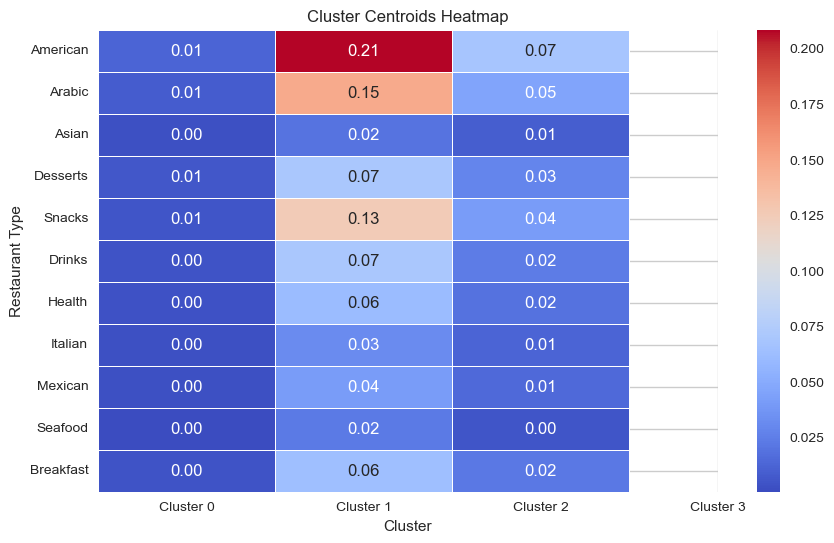

In [47]:
plt.figure(figsize=(10,6))
sns.heatmap(centroids.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(ticks=np.arange(4) + 0.5, labels=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"])
plt.title("Cluster Centroids Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Restaurant Type")
plt.show()

In [48]:
trim_df.sum()

customer_id       000THBA002510Y005ECL60075AM7009UFS100F8I3F00FQ...
American                                                     149114
Arabic                                                        55529
Asian                                                         44608
Desserts                                                      91772
Snacks                                                        11158
Drinks                                                        45438
Health                                                       113955
Italian                                                       51856
Mexican                                                        3154
Seafood                                                         606
Breakfast                                                     38124
KMeans_Cluster                                                 8193
dtype: object

Still isn't showing meaningful clusters due to imbalance data as shown above. Some tags are overrepresented. To Prevent dominance, try log scaling and TF-IDF to prevent overweight influence of frequent tags.

In [49]:
# try log scaling
numerical_columns = [col for col in trim_df.columns if col not in ['customer_id', 'KMeans_Cluster']]
# Apply log scaling (log1p to handle zero values)
log_transformer = FunctionTransformer(np.log1p, validate=True)
trimmed_df_log_scaled = trim_df.copy()
trimmed_df_log_scaled[numerical_columns] = log_transformer.transform(trim_df[numerical_columns])

/opt/anaconda3/envs/zfq0/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [50]:
trimmed_df_log_scaled.drop(columns=['KMeans_Cluster'])
optimal_k = 3
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(trimmed_df_log_scaled.drop(columns=['customer_id']))
kmeans = KMeans(n_clusters=optimal_k, random_state=123, n_init=10)
trimmed_df_log_scaled['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

In [51]:
centroids = pd.DataFrame(kmeans.cluster_centers_,columns=trimmed_df_log_scaled.columns[:-1]).drop(columns=['customer_id'])
centroids

,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast
0,0.078182,0.044226,0.093983,0.024690,0.047129,0.093262,0.038580,0.007805,0.000572,0.039034,-3.885781e-15
1,0.337783,0.143382,0.373326,0.192875,0.258740,0.361638,0.243346,0.053174,0.017077,0.275741,9.430249e-01
2,0.155772,0.082381,0.241049,0.043803,0.105649,0.235416,0.139939,0.013298,0.003315,0.147532,1.998401e-15


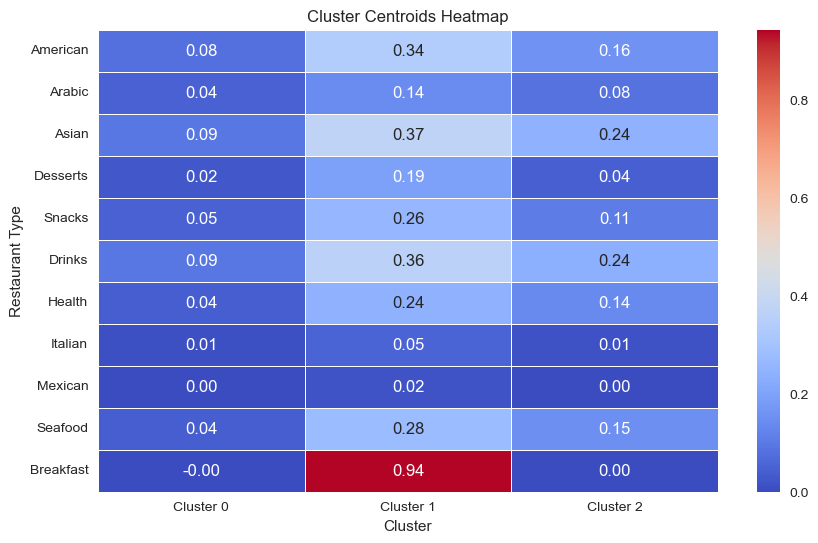

In [52]:
plt.figure(figsize=(10,6))
sns.heatmap(centroids.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(ticks=np.arange(3) + 0.5, labels=["Cluster 0", "Cluster 1", "Cluster 2"])
plt.title("Cluster Centroids Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Restaurant Type")
plt.show()

It looks better but cluster 0 is still too generalized. Try TF-IDF.

In [53]:
tfidf_transformer = TfidfTransformer()
tfidf_scaled = tfidf_transformer.fit_transform(trim_df[numerical_columns])
trimmed_df_tfidf_scaled = trim_df.copy()
trimmed_df_tfidf_scaled[numerical_columns] = pd.DataFrame(tfidf_scaled.toarray(), columns=numerical_columns)
trimmed_df_tfidf_scaled.head()

,customer_id,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast,KMeans_Cluster
0,000THBA,0.639155,0.390793,0.000000,0.000000,0.000000,0.0,0.294909,0.424689,0.0,0.0,0.414041,0
1,002510Y,0.000000,0.000000,0.981434,0.139184,0.000000,0.0,0.131964,0.000000,0.0,0.0,0.000000,0
2,005ECL6,0.690752,0.000000,0.000000,0.224103,0.445452,0.0,0.424955,0.305982,0.0,0.0,0.000000,0
3,0075AM7,0.000000,0.602969,0.000000,0.000000,0.000000,0.0,0.455027,0.655270,0.0,0.0,0.000000,0
4,009UFS1,0.726417,0.507596,0.000000,0.202006,0.000000,0.0,0.287290,0.137906,0.0,0.0,0.268896,0


In [54]:
trimmed_df_tfidf_scaled.drop(columns=['KMeans_Cluster'])
optimal_k = 3
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(trimmed_df_tfidf_scaled.drop(columns=['customer_id']))
kmeans = KMeans(n_clusters=optimal_k, random_state=123, n_init=10)
trimmed_df_tfidf_scaled['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

In [55]:
trimmed_df_tfidf_scaled.head()

,customer_id,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast,KMeans_Cluster
0,000THBA,0.639155,0.390793,0.000000,0.000000,0.000000,0.0,0.294909,0.424689,0.0,0.0,0.414041,1
1,002510Y,0.000000,0.000000,0.981434,0.139184,0.000000,0.0,0.131964,0.000000,0.0,0.0,0.000000,2
2,005ECL6,0.690752,0.000000,0.000000,0.224103,0.445452,0.0,0.424955,0.305982,0.0,0.0,0.000000,1
3,0075AM7,0.000000,0.602969,0.000000,0.000000,0.000000,0.0,0.455027,0.655270,0.0,0.0,0.000000,2
4,009UFS1,0.726417,0.507596,0.000000,0.202006,0.000000,0.0,0.287290,0.137906,0.0,0.0,0.268896,1


In [56]:
centroids = pd.DataFrame(kmeans.cluster_centers_,columns=trimmed_df_tfidf_scaled.columns[:-1]).drop(columns=['customer_id'])
centroids

,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast
0,0.228010,0.148728,0.307010,0.111474,0.229127,0.369325,0.211629,0.032857,0.011539,0.227090,0.960187
1,0.098499,0.021855,0.280492,0.041621,0.077599,0.334917,0.277244,0.017422,0.001544,0.177412,0.004789
2,0.315895,0.332730,0.264261,0.079475,0.258359,0.275714,0.060504,0.027496,0.006177,0.141592,0.001872


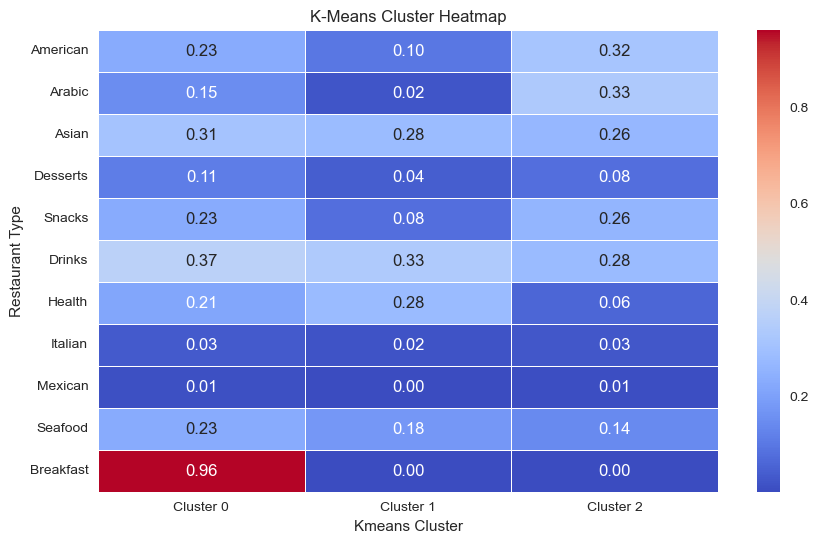

In [79]:
plt.figure(figsize=(10,6))
sns.heatmap(centroids.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(ticks=np.arange(3) + 0.5, labels=["Cluster 0", "Cluster 1", "Cluster 2"])
plt.title("K-Means Cluster Heatmap")
plt.xlabel("Kmeans Cluster")
plt.ylabel("Restaurant Type")
plt.show()

It looks much better now.

Cluster 0: Dominated by Breakfast. Moderate representation from Drinks (0.37), Asian (0.31), and American/Seafood/Snacks (0.23). Label: Breakfast Lovers

Cluster 1: Relatively higher proportions for Drinks (0.33), Health (0.28), and Asian (0.28). Label: Healthy & Beverage Lovers

Cluster 2: Arabic (0.33), American (0.32), and Drinks/Health (0.28) are well represented. Asian (0.26), Snacks (0.26) also have moderate presence. Label: Global Cuisine Lovers

## 2.2 K-Modes Clustering

In [58]:
X_tfidf=trimmed_df_tfidf_scaled.drop(columns=['customer_id'])
X_tfidf.head()

,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast,KMeans_Cluster
0,0.639155,0.390793,0.000000,0.000000,0.000000,0.0,0.294909,0.424689,0.0,0.0,0.414041,1
1,0.000000,0.000000,0.981434,0.139184,0.000000,0.0,0.131964,0.000000,0.0,0.0,0.000000,2
2,0.690752,0.000000,0.000000,0.224103,0.445452,0.0,0.424955,0.305982,0.0,0.0,0.000000,1
3,0.000000,0.602969,0.000000,0.000000,0.000000,0.0,0.455027,0.655270,0.0,0.0,0.000000,2
4,0.726417,0.507596,0.000000,0.202006,0.000000,0.0,0.287290,0.137906,0.0,0.0,0.268896,1


In [59]:
num_clusters = 5  
# Apply K-Modes clustering
kmodes = KModes(n_clusters=num_clusters, init='Huang', n_init=5, random_state=123)
trimmed_df_tfidf_scaled['KModes_Cluster'] = kmodes.fit_predict(X_tfidf)

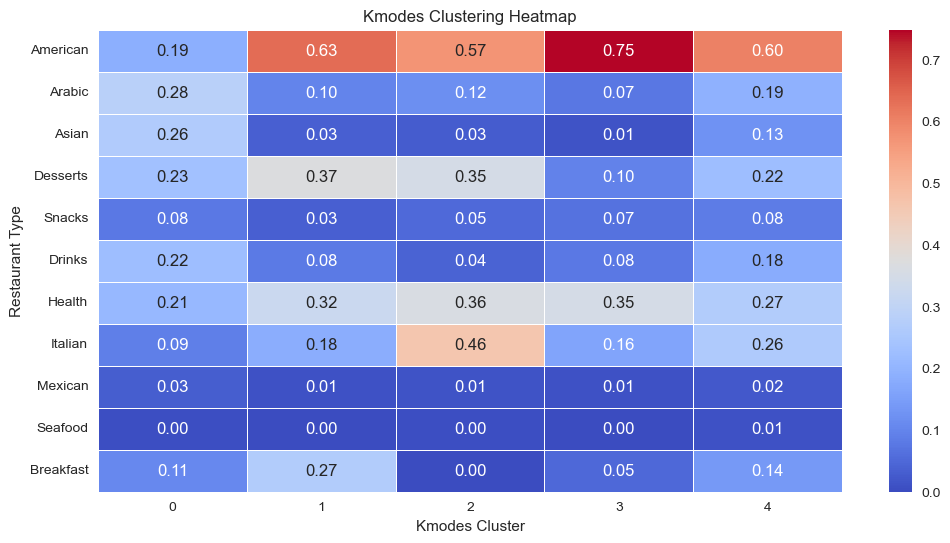

In [60]:
numerical_columns = [col for col in trimmed_df_tfidf_scaled.columns if col not in ['customer_id','KMeans_Cluster', 'Hierarchical_Cluster','KModes_Cluster']]
cluster_centroids = trimmed_df_tfidf_scaled.groupby("KModes_Cluster")[numerical_columns].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_centroids.T, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Kmodes Clustering Heatmap")
plt.xlabel("Kmodes Cluster")
plt.ylabel("Restaurant Type")
plt.show()

Cluster 0: Not super strong in any one category but moderate interest in Arabic (0.28), Asian (0.26), Desserts (0.23), Drinks (0.22), Health (0.21). Label: Global Taste Lovers

Cluster 1: High on Breakfast (0.27), Desserts (0.37), Health (0.32), and Italian (0.18). Label: Breakfast & Dessert Lovers

Cluster 2: Strong on Italian (0.46), Health (0.36), and Desserts (0.35). Label: Italian & Health Lovers

Cluster 3: Very high American (0.75), and some Health (0.35). Label: American Food Lovers

Cluster 4: Strong on American (0.60), Health (0.27), Italian (0.26), and moderate Breakfast (0.14). Label: Comfort Food Lovers

## 2.3 Hierarchical Clustering

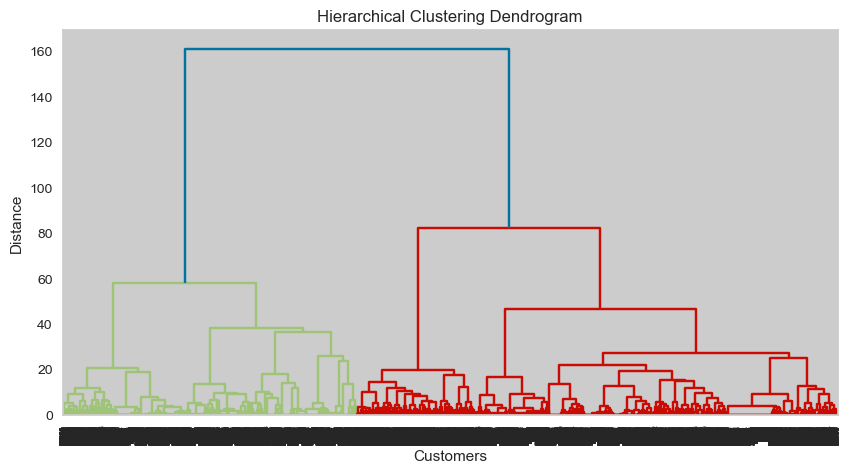

In [61]:
linkage_matrix = linkage(X_tfidf, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

In [62]:
num_clusters = 3
trimmed_df_tfidf_scaled['Hierarchical_Cluster'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
trimmed_df_tfidf_scaled

,customer_id,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast,KMeans_Cluster,KModes_Cluster,Hierarchical_Cluster
0,000THBA,0.639155,0.390793,0.000000,0.000000,0.000000,0.000000,0.294909,0.424689,0.0,0.0,0.414041,1,3,3
1,002510Y,0.000000,0.000000,0.981434,0.139184,0.000000,0.000000,0.131964,0.000000,0.0,0.0,0.000000,2,0,1
2,005ECL6,0.690752,0.000000,0.000000,0.224103,0.445452,0.000000,0.424955,0.305982,0.0,0.0,0.000000,1,2,3
3,0075AM7,0.000000,0.602969,0.000000,0.000000,0.000000,0.000000,0.455027,0.655270,0.0,0.0,0.000000,2,0,1
4,009UFS1,0.726417,0.507596,0.000000,0.202006,0.000000,0.000000,0.287290,0.137906,0.0,0.0,0.268896,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27437,ZZVGIVK,0.153596,0.000000,0.000000,0.298989,0.000000,0.000000,0.425218,0.816458,0.0,0.0,0.198997,1,1,3
27438,ZZVLIB5,0.202301,0.000000,0.961204,0.015146,0.000000,0.069493,0.172325,0.000000,0.0,0.0,0.020161,2,0,1
27439,ZZWKMGG,0.000000,0.365228,0.000000,0.000000,0.000000,0.889182,0.275617,0.000000,0.0,0.0,0.000000,2,0,1
27440,ZZY3N0D,0.380032,0.290449,0.000000,0.277414,0.091903,0.777838,0.175348,0.126257,0.0,0.0,0.184637,0,4,2


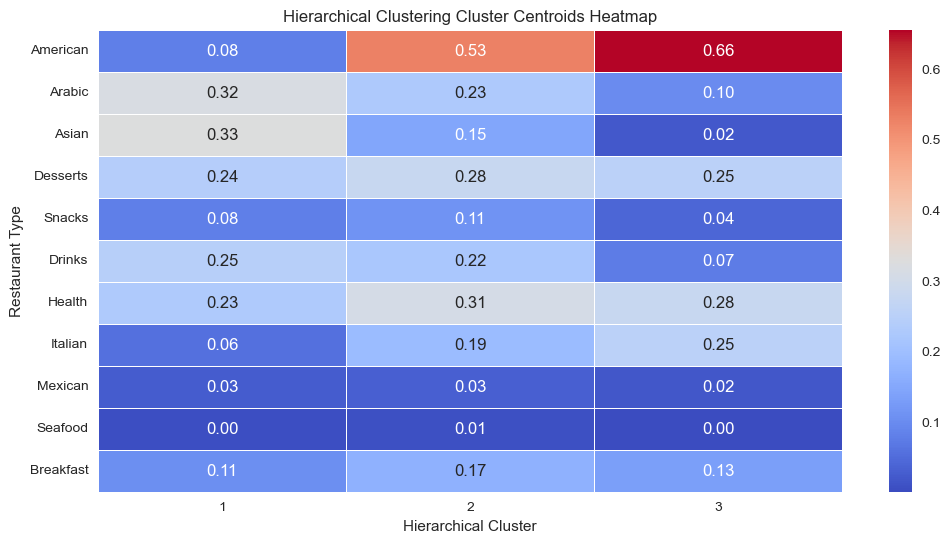

In [70]:
numerical_columns = [col for col in trimmed_df_tfidf_scaled.columns if col not in ['customer_id','KMeans_Cluster', 'KModes_Cluster', 'Hierarchical_Cluster']]
cluster_centroids = trimmed_df_tfidf_scaled.groupby("Hierarchical_Cluster")[numerical_columns].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_centroids.T, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Hierarchical Clustering Cluster Centroids Heatmap")
plt.xlabel("Hierarchical Cluster")
plt.ylabel("Restaurant Type")
plt.show()

Cluster 1: High preference for Asian (0.33), Arabic (0.32), Drinks (0.25), Desserts (0.24), and Health (0.23). Label: Global Variety Lovers

Cluster 2: Fairly even interest across American (0.53), Desserts (0.28), Health (0.31), Breakfast (0.17), and Italian (0.19). Label: Balanced Food Lovers

Cluster 3: Very strong preference for American (0.66). Moderate interest in Italian (0.25) and Health (0.28). Label: American Food Lovers

# 3. Combine RFM with Cuisine Preferences

In [64]:
df_segment.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,latitude,longitude,latitude_vendor,longtitude_vendor,vendor_category_en,delivery_charge,vendor_tag_name,order_date,Segment,year_month
0,163238.0,92PEE24,1.0,7.6,2,0,0.0,0.0,No,No,...,-0.132100,-78.575297,-0.967769,0.080839,Restaurants,0.0,"American,Burgers,Free Delivery,Hot Dogs,Pasta",2019-08-01,churn_user,2019-08
1,163240.0,QS68UD8,1.0,8.7,1,0,0.0,0.0,No,No,...,-0.393396,-78.544417,-1.271979,0.028832,Restaurants,0.0,"Burgers,Desserts,Free Delivery,Grills,Mexican",2019-08-01,churn_user,2019-08
2,163241.0,MB7VY5F,2.0,14.4,1,0,0.0,0.0,No,No,...,-1.072823,-78.464121,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic",2019-08-01,churn_user,2019-08
3,163244.0,KDJ951Y,1.0,7.1,1,0,0.0,0.0,No,No,...,-0.292713,-78.556316,-0.601096,0.095998,Restaurants,0.0,"American,Burgers,Desserts,Mojitos ,Pasta",2019-08-01,churn_user,2019-08
4,163245.0,BAL0RVT,4.0,27.2,1,0,0.0,0.0,No,No,...,-0.231810,-78.563513,-0.927944,0.145900,Restaurants,0.7,"Breakfast,Desserts,Salads,Arabic",2019-08-01,regular_user,2019-08


In [65]:
trimmed_df_tfidf_scaled.head()

,customer_id,American,Arabic,Asian,Desserts,Snacks,Drinks,Health,Italian,Mexican,Seafood,Breakfast,KMeans_Cluster,KModes_Cluster,Hierarchical_Cluster
0,000THBA,0.639155,0.390793,0.000000,0.000000,0.000000,0.0,0.294909,0.424689,0.0,0.0,0.414041,1,3,3
1,002510Y,0.000000,0.000000,0.981434,0.139184,0.000000,0.0,0.131964,0.000000,0.0,0.0,0.000000,2,0,1
2,005ECL6,0.690752,0.000000,0.000000,0.224103,0.445452,0.0,0.424955,0.305982,0.0,0.0,0.000000,1,2,3
3,0075AM7,0.000000,0.602969,0.000000,0.000000,0.000000,0.0,0.455027,0.655270,0.0,0.0,0.000000,2,0,1
4,009UFS1,0.726417,0.507596,0.000000,0.202006,0.000000,0.0,0.287290,0.137906,0.0,0.0,0.268896,1,1,3


In [75]:
segment1 = df_segment.merge(trimmed_df_tfidf_scaled[['customer_id', 'KMeans_Cluster', 'Hierarchical_Cluster','KModes_Cluster']], on='customer_id', how='left')
cluster_name_mapping_kmeans = {
    0: "Breakfast Lovers",
    1: "Healthy & Beverage Lovers",
    2: "Global Cuisine Lovers"
}
cluster_name_mapping_hc = {
    1: "Global Variety Lovers",
    2: "Balanced Food Lovers",
    3: "American Food Lovers"
}
cluster_name_mapping_km = {
    0: "Global Taste Lovers",
    1: "Breakfast & Dessert Lovers",
    2: "Italian & Health Lovers",
    3: "American Food Lovers",
    4: "Comfort Food Lovers"
}
segment1['KMeans_Cluster'] = segment1['KMeans_Cluster'].map(cluster_name_mapping_kmeans)
segment1['Hierarchical_Cluster'] = segment1['Hierarchical_Cluster'].map(cluster_name_mapping_hc)
segment1['KModes_Cluster']= segment1['KModes_Cluster'].map(cluster_name_mapping_km)

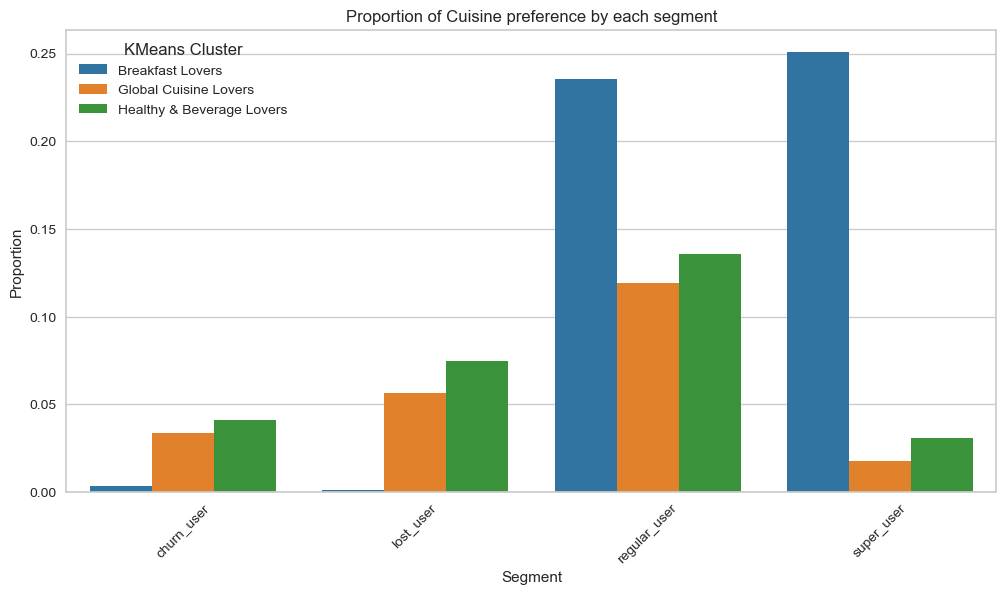

In [76]:
# use kmeans
cluster_distribution = segment1.groupby(['Segment', 'KMeans_Cluster']).size().div(len(df_segment)).reset_index()
cluster_distribution.columns = ['Segment', 'KMeans_Cluster', 'Proportion']
# Plot the proportion of each KMeans cluster within each segment
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_distribution, x="Segment", y="Proportion", hue="KMeans_Cluster", palette="tab10")

# Customize the plot
plt.title("Proportion of Cuisine preference by each segment")
plt.xlabel("Segment")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="KMeans Cluster")

# Show the plot
plt.show()

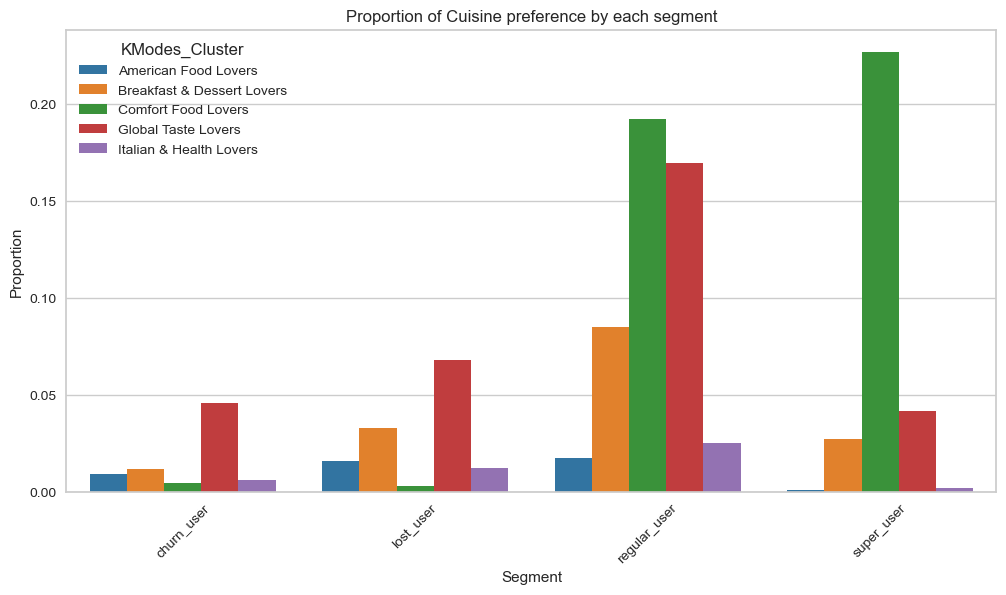

In [77]:
# use kmodes
cluster_distribution = segment1.groupby(['Segment', 'KModes_Cluster']).size().div(len(df_segment)).reset_index()
cluster_distribution.columns = ['Segment', 'KModes_Cluster', 'Proportion']
# Plot the proportion of each KMeans cluster within each segment
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_distribution, x="Segment", y="Proportion", hue="KModes_Cluster", palette="tab10")

# Customize the plot
plt.title("Proportion of Cuisine preference by each segment")
plt.xlabel("Segment")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="KModes_Cluster")

# Show the plot
plt.show()

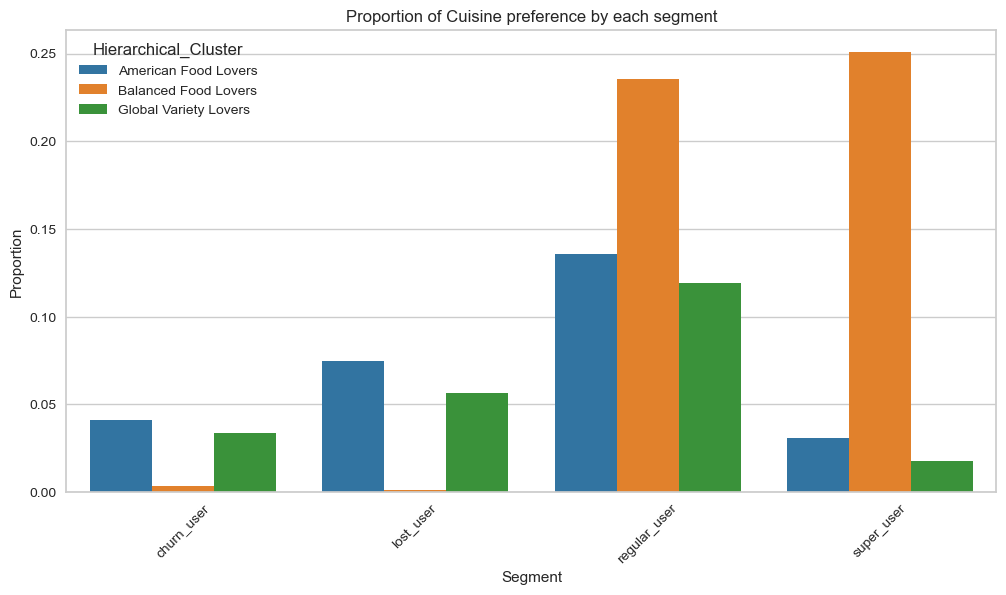

In [78]:
# use Hierarchical clustering
cluster_distribution = segment1.groupby(['Segment', 'Hierarchical_Cluster']).size().div(len(df_segment)).reset_index()
cluster_distribution.columns = ['Segment', 'Hierarchical_Cluster', 'Proportion']
# Plot the proportion of each KMeans cluster within each segment
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_distribution, x="Segment", y="Proportion", hue="Hierarchical_Cluster", palette="tab10")

# Customize the plot
plt.title("Proportion of Cuisine preference by each segment")
plt.xlabel("Segment")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Hierarchical_Cluster")

# Show the plot
plt.show()